# Рекомендация тарифов

## Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».


В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — она уже сделана проектом ранее.


Постройте модель с максимально большим значением accuracy (нужно довести долю правильных ответов по крайней мере до 0.75).

## Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Изучение общей инофрмации о данных

**Вывод по шагу 1.**

Перед нами стоит задача классификации. **Целевой признак** - *is_ultra.* Остальные признаки помогут предсказывать решение по целевому признаку is_ultra.

Из-за того, что данных не очень много, модель может быть переобученной.

*Предобработка данных не требуется, несмотря на то, что это было указано в описании задания, никогда не бывает лишним проверить названия столбцов, наличие дубликатов и пропусков (по общей информации видно, что их нет).*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from tqdm import tqdm
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
tariff_data = pd.read_csv('/datasets/users_behavior.csv')
tariff_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [3]:
tariff_data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
print(tariff_data.corr())

             calls   minutes  messages   mb_used  is_ultra
calls     1.000000  0.982083  0.177385  0.286442  0.207122
minutes   0.982083  1.000000  0.173110  0.280967  0.206955
messages  0.177385  0.173110  1.000000  0.195721  0.203830
mb_used   0.286442  0.280967  0.195721  1.000000  0.198568
is_ultra  0.207122  0.206955  0.203830  0.198568  1.000000


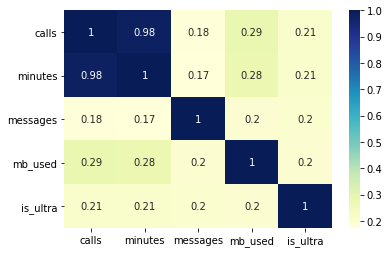

In [5]:
tariff_data_plot = sns.heatmap(tariff_data.corr(), cmap="YlGnBu", annot=True)

In [6]:
X = add_constant(tariff_data)  
ds=pd.Series([variance_inflation_factor(X.values, i)   
               for i in range(X.shape[1])],   
              index=X.columns)  
print(ds)

const        8.077246
calls       28.283590
minutes     28.172344
messages     1.083318
mb_used      1.133531
is_ultra     1.094911
dtype: float64


## Разделение данных на выборки
**Вывод по шагу 2**

Данные были разбиты по принципу 60/20/20.

- Обучение пройдет на данных train_tariff_data
- Валидация модели на данных valid_tariff_data
- Лучшая модель по валидации будет применена на данных test_tariff_data

In [7]:
#Разобьём выборки на обучающию, валидационную, тестовую в соответствии с принципом 60/20/20
train_tariff_data, vnt_tariff_data = train_test_split(tariff_data, test_size=0.40, random_state=12345)
valid_tariff_data, test_tariff_data = train_test_split(vnt_tariff_data, test_size=0.50, random_state=12345)

print('Размер обучающей выборки', train_tariff_data.shape[0])
print('Размер валидационной выборки', valid_tariff_data.shape[0])
print('Размер тестовой выборки', test_tariff_data.shape[0])

Размер обучающей выборки 1928
Размер валидационной выборки 643
Размер тестовой выборки 643


In [8]:
#Составим таблицы признаков и целового признака для каждого датафрейма

train_tariff_data_features = train_tariff_data.drop(['is_ultra'], axis=1)
train_tariff_data_target = train_tariff_data['is_ultra']

valid_tariff_data_features = valid_tariff_data.drop(['is_ultra'], axis=1)
valid_tariff_data_target = valid_tariff_data['is_ultra']

test_tariff_data_features = test_tariff_data.drop(['is_ultra'], axis=1)
test_tariff_data_target = test_tariff_data['is_ultra']

# Исследование моделей

**Вывод по шагу 2**

В ходе исследования были получены следующие данные:

- Точность модели решающего дерева при глубине 3 равна 0.78. Время выполнения код и обучения 0,86 секунд.
- Точность модели случайного леса при количестве деревьев 11 равна 0.83. Время выполнения код и обучения 7,5 секунд.
- Точность модели логистической регресии равна 0.762. Время выполнения код и обучения 5,91 секунд.

Так как выборка небольшая, то лучший результат показывает решающее древо с гиперпараметром max_depth=8.

### Древо выбора

In [9]:
%%time
best_accuracy = 0
best_depth = 0
for depth in range(1,12):
    model = DecisionTreeClassifier(max_depth=depth, random_state=412)
    model.fit(train_tariff_data_features, train_tariff_data_target)
    accuracy = model.score(valid_tariff_data_features, valid_tariff_data_target)
    if accuracy > best_accuracy:
        print("Глубина дерева:", depth, "качество:" ,accuracy)
        best_accuracy = accuracy
        best_depth = depth
print("Лучшая глубина дерева:", best_depth, "Лучшее Качество:", best_accuracy)

Глубина дерева: 1 качество: 0.7542768273716952
Глубина дерева: 2 качество: 0.7822706065318819
Глубина дерева: 3 качество: 0.7853810264385692
Лучшая глубина дерева: 3 Лучшее Качество: 0.7853810264385692
CPU times: user 91.4 ms, sys: 0 ns, total: 91.4 ms
Wall time: 92.1 ms


### Случайный лес

In [ ]:
%time
clf = RandomForestClassifier()
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(train_tariff_data_features, train_tariff_data_target)

In [11]:
#Подбор параметров с помощью GridSearchCV
%time
clf = RandomForestClassifier()
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(valid_tariff_data_features, valid_tariff_data_target)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.34 µs


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 13, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10)})

In [13]:
grid.best_score_

0.7870639534883721

### Логистическая регрессия

In [14]:
%%time

best_max_iter = 0
best_accuracy = 0

for max_iter in range(1,10):
    model = LogisticRegression(random_state=23042020, max_iter=max_iter)
    model.fit(train_tariff_data_features, train_tariff_data_target)
    valid_predictions = model.predict(valid_tariff_data_features)
    accuracy = accuracy_score(valid_tariff_data_target, valid_predictions)
    print('Количество итерраций', max_iter,'Точность',accuracy)
    if accuracy > best_accuracy:
        best_max_iter = max_iter
        best_accuracy = accuracy

print('Лучшее количество итерраций', best_max_iter,'Лучшая точность', best_accuracy) 

Количество итерраций 1 Точность 0.7060653188180405
Количество итерраций 2 Точность 0.7060653188180405
Количество итерраций 3 Точность 0.7060653188180405
Количество итерраций 4 Точность 0.7060653188180405
Количество итерраций 5 Точность 0.7060653188180405
Количество итерраций 6 Точность 0.7060653188180405
Количество итерраций 7 Точность 0.7060653188180405
Количество итерраций 8 Точность 0.7060653188180405
Количество итерраций 9 Точность 0.7060653188180405
Лучшее количество итерраций 1 Лучшая точность 0.7060653188180405
CPU times: user 87 ms, sys: 38 µs, total: 87 ms
Wall time: 96.7 ms


## Проверка модели на тестовой выборке

**Вывод по шагу 4**

Для решения поставленной задачи можно выбрать модель случайного леса (точность 0.78). Интересно, что в обучающей выборке наибольшая точность была достигнута при модели решающего древа. Учитывая разницу между текущей точностью и точностью на валидационной выборке, можно сделать вывод слабой переобученности модели.

In [16]:
#Оценим точность модели случайного леса на тестовой выборке.
test_predictions = grid.predict(test_tariff_data_features)
accuracy = accuracy_score(test_tariff_data_target, test_predictions)
print('Точность модели случайного леса на тестовой выборке',accuracy)

Точность модели случайного леса на тестовой выборке 0.7744945567651633


## Проверка модели на адекватность


In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=12345)

dummy_clf.fit(train_tariff_data_features, train_tariff_data_target)

dummy_clf.score(train_tariff_data_features, train_tariff_data_target)


## Общий вывод

В ходе проделанной работы было выполнено:

1. Изучен файл с данными.
2. Разбиты данные на три выборки: обучающая, валидационная и тестовая.
3. Исследованы три модели классификации: Решающее дерево, Случайный лес и Логистическая регрессия.
4. Найдены оптимальные параметры для каждой модели и выбрана одна из них для обучения модели (модель случайного леса).
5. Оценена точность обученной модели (для модели случайного леса точность 0.78).
6. Оценена адекватность модели (F-мера = 0.6045197740112994).

Для обучения модели было использована выборка в 2000 значений. Этого может быть недостаточно для повышения ключевых параметров модели классификатора. Увеличение в 10 или 100 увеличит accuracy, precision и recall, а также время обучения.

Адекватность модели повышается с ростом количества значений.